In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


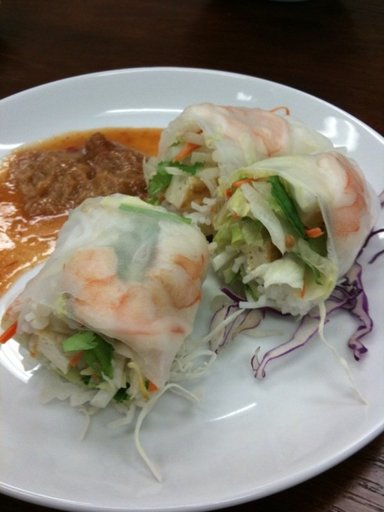

In [2]:
from IPython.display import Image
Image('/content/gdrive/My Drive/Hotdog/hot-dog-not-hot-dog/train/not_hot_dog/197.jpg')

In [0]:
import torch
import pickle as pkl
from matplotlib import pyplot as plt
import torch
import numpy as np
from torchvision import transforms
from torchvision import datasets
import os

In [0]:
def get_data(batch_size,image_size,path='/content/gdrive/My Drive/Hotdog/hot-dog-not-hot-dog/'):
  
    normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
  
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalization
    ])
    
    dataset_train = datasets.ImageFolder(os.path.join(path,'train'),transform = transform)
    dataset_test = datasets.ImageFolder(os.path.join(path,'test'),transform = transform)
    
    dataloader_train = torch.utils.data.DataLoader(dataset = dataset_train,batch_size = batch_size,shuffle=True)  
    dataloader_test = torch.utils.data.DataLoader(dataset = dataset_test,batch_size = batch_size,shuffle=True)  
    
    return dataloader_train,dataloader_test
  
data_train,data_test = get_data(50,256)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50])


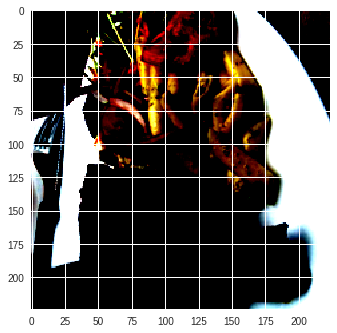

In [5]:
for idx,(data,label) in enumerate(data_train):
  if idx == 1 :
    print(np.shape(label))
    npimg = data[3].numpy()
    plt.imshow(np.transpose(npimg))
    break

In [0]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [7]:
model = models.vgg16(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

use_cuda = torch.cuda.is_available()

print(use_cuda)

if use_cuda:
  model = model.cuda()


True


In [8]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
model.classifier = nn.Sequential(nn.Linear(25088,4096),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(0.3),
                                 nn.Linear(4096,128),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout(0.3),
                                 nn.Linear(128,2))

In [10]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [0]:
def train(epochs,loaders,model,optimizer,criterion,use_cuda,path):
  
  for epoch in range(0,epochs+1):
    
    train_loss = 0.0
    
    model.train()
    
    for idx,(data,target) in enumerate(loaders):
      
      if use_cuda :
        
        data = data.cuda()
        target = target.cuda()
        
      optimizer.zero_grad()
      
      output = model(data)
      
      loss = criterion(output,target)
      
      loss.backward()
      
      optimizer.step()
      
      train_loss = train_loss + ((1 / (idx +1)) * (loss.data - train_loss))
      
      if idx % 4 == 0:
        print('Epoch %d,Batch %d,Loss %.6f'% (epoch,idx+1,train_loss))
        
      if epoch % 5 == 0:
        torch.save(model.state_dict(),path)
        
  return model

In [13]:
epochs = 10

model.cuda()

path = 'hot_dog_model.pt'

train(epochs,data_train,model,optimizer,criterion,use_cuda,path)

model.load_state_dict(torch.load(path))

Epoch 0,Batch 1,Loss 0.750260
Epoch 0,Batch 5,Loss 0.561072
Epoch 0,Batch 9,Loss 0.475664
Epoch 1,Batch 1,Loss 0.098971
Epoch 1,Batch 5,Loss 0.070911
Epoch 1,Batch 9,Loss 0.082925
Epoch 2,Batch 1,Loss 0.020840
Epoch 2,Batch 5,Loss 0.024887
Epoch 2,Batch 9,Loss 0.023171
Epoch 3,Batch 1,Loss 0.010505
Epoch 3,Batch 5,Loss 0.007509
Epoch 3,Batch 9,Loss 0.005903
Epoch 4,Batch 1,Loss 0.002877
Epoch 4,Batch 5,Loss 0.004148
Epoch 4,Batch 9,Loss 0.003696
Epoch 5,Batch 1,Loss 0.002646
Epoch 5,Batch 5,Loss 0.001639
Epoch 5,Batch 9,Loss 0.001339
Epoch 6,Batch 1,Loss 0.002385
Epoch 6,Batch 5,Loss 0.001435
Epoch 6,Batch 9,Loss 0.001512
Epoch 7,Batch 1,Loss 0.001167
Epoch 7,Batch 5,Loss 0.000643
Epoch 7,Batch 9,Loss 0.000945
Epoch 8,Batch 1,Loss 0.001105
Epoch 8,Batch 5,Loss 0.000731
Epoch 8,Batch 9,Loss 0.000567
Epoch 9,Batch 1,Loss 0.000168
Epoch 9,Batch 5,Loss 0.000391
Epoch 9,Batch 9,Loss 0.000360
Epoch 10,Batch 1,Loss 0.000319
Epoch 10,Batch 5,Loss 0.000391
Epoch 10,Batch 9,Loss 0.000411


In [0]:
def test(loaders,model,criterion,use_cuda):
  
  test_loss = 0.
  correct = 0.
  total = 0.
  
  model.eval()
  
  for idx ,(data,target) in enumerate(loaders):
    
    if use_cuda:
      
      data = data.cuda()
      target = target.cuda()
      
    output = model(data)
    
    loss = criterion(output,target)
    
    test_loss = test_loss + ((1 / (idx +1)) * (loss.data - test_loss))
    
    pred = output.data.max(1, keepdim=True)[1]
    
    correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        
    total += data.size(0)
    
  print('Test Loss: %.6f\n'%(test_loss))

  print('Test Accuracy: %2d%% (%2d/%2d)' % ((100. * correct/total),correct,total))

In [15]:
model.cuda()

test(data_test,model,criterion,use_cuda)

Test Loss: 0.346268

Test Accuracy: 90% (451/500)
